In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from datetime import timedelta

In [2]:
""" Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
and m the nbr of datapoints from a python readout of the WLM. Check that each mesure has the amount of channel fixed by 
the first line and that there is no reset of the time (else compensate for it) """
def ReadDataPythonReadOut(path_name):
    with open(path_name, 'r') as file:
        Data = file.read()

    Data = Data.split("\n")

    # Initialize
    res = np.zeros((len(Data[0].split(" ")), len(Data)))
    try:
        res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
    except: # If error in reading (not everything is measured), return nothing
        print("Error initialization")
        return res
    
    time_offset = 0 # If time reinitialized, keep time increasing

    # Import the data line by line
    for i in range(1, len(Data)):
        try:
            res[:, i] = np.array(Data[i].split(" "), dtype=float)

            # Fix jumping time
            res[0, i] = res[0, i] + time_offset
            if res[0, i] < res[0, i-1]: # Time is not increasing
                time_offset = res[0, i-1] + np.mean(res[0, 1:i]-res[0, :i-1]) # Time reset -> offset = previous time + mean DeltaT
                res[0, i] = time_offset
                print("Time problem line "+str(i))

        except: # If error in reading (not everything is measured), put -1 for the time
            print("Error line "+str(i))
            res[0, i] = -1
    return res

# Recover Data

In [3]:
# path_name = r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\DataWeekend_2025_09_26_Lambda_P_T_temp.txt"
# path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Server_Python\SavedData\Data_Drift_WLM_Night_2025_10_09_Lambdas_P_T.txt"
# path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Drift_Measure\SavedData\Data_Drift_WLM_Night_2025_10_08_Lambdas_P_T_saved.txt"
# path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Drift_Measure\SavedData\Data_Drift_WLM_Night_2025_10_07_Lambdas_P_T_temp.txt"
# path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Server_Python\SavedData\Data_Drift_WLM_Lambdas_P_T_2025_10_13_15h.txt"
# path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Server_Python\SavedData\Data_Drift_WLM_10h_2025_10_10_Lambdas_P_T.txt"
path_name = r"C:\Users\Joschka\Desktop\Remy\Codes\Laser_PID\WLM_Drift_Measure\SavedData\Data_Drift_WLM_Lambdas_P_T_2025_10_15_09h.txt"

Data = ReadDataPythonReadOut(path_name)
T, Lambdas, Pressure, Temperature = Data[0], Data[1:-2], Data[-2], Data[-1]
T, Lambdas, Pressure, Temperature = T[T!=-1], Lambdas[:, T!=-1], Pressure[T!=-1], Temperature[T!=-1] # Remove lines where every channel was not saved
print("Acquisition time = "+str(timedelta(seconds=T[-1]*1e-3)))

Error line 179500
Acquisition time = 1 day, 1:00:16.700257


In [4]:
# Remove acquisition when reading of the wavelength is zero
cutoff_std_lambda = 10 # Distance from mean above which data is absurd
Absurd_Lambdas = np.abs([L-np.mean(L) for L in Lambdas]) < cutoff_std_lambda # Remove the data points where the wavelength distance from the mean is bigger than cutoff_std_lambda
Absurd_Lambdas_intersect = np.ones(len(T), dtype=bool)
for Al in Absurd_Lambdas:
    Absurd_Lambdas_intersect *= Al
Absurd_Lambdas_intersect
T, Lambdas, Pressure, Temperature = T[Absurd_Lambdas_intersect], Lambdas[:, Absurd_Lambdas_intersect], Pressure[Absurd_Lambdas_intersect], Temperature[Absurd_Lambdas_intersect]

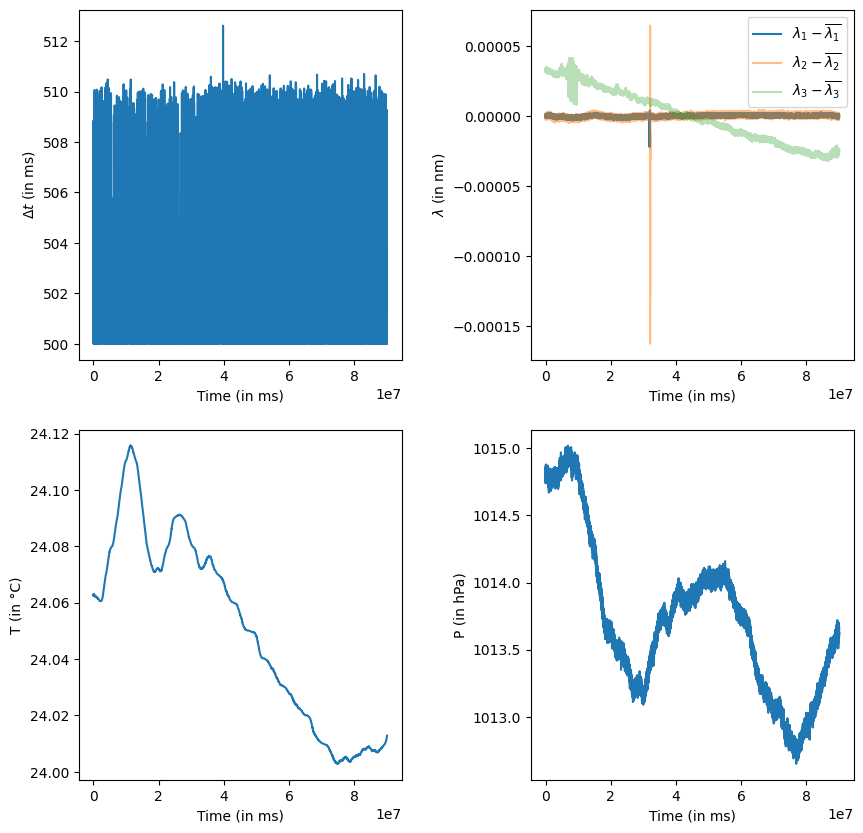

In [5]:
%matplotlib inline
plt.close()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.4)
axes[0, 0].plot(T[1:], T[1:]-T[:-1])
axes[0, 0].set_xlabel("Time (in ms)")
axes[0, 0].set_ylabel(r"$\Delta t$ (in ms)")

for i in range(len(Lambdas)):
    axes[0, 1].plot(T, Lambdas[i]-np.mean(Lambdas[i]), label=r"$\lambda_%d - \overline{\lambda_%d}$" %(i+1, i+1), alpha=1/(i+1))
axes[0, 1].legend()
axes[0, 1].set_xlabel("Time (in ms)")
axes[0, 1].set_ylabel(r"$\lambda$ (in nm)")

axes[1, 0].plot(T, Temperature)
axes[1, 0].set_xlabel("Time (in ms)")
axes[1, 0].set_ylabel("T (in °C)")

axes[1, 1].plot(T, Pressure)
axes[1, 1].set_xlabel("Time (in ms)")
axes[1, 1].set_ylabel("P (in hPa)")

plt.show()

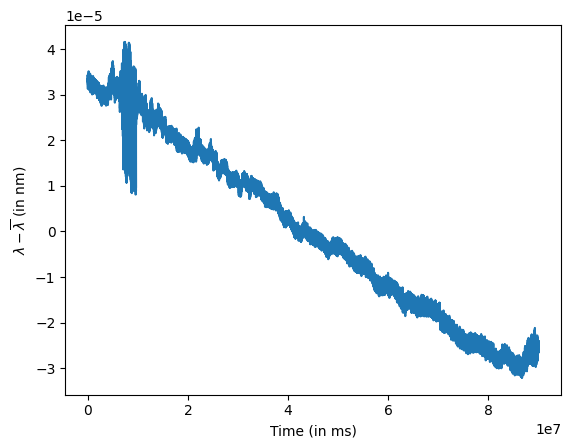

In [20]:
# Plot evolution 530nm only
%matplotlib inline
plt.close()
fig, ax = plt.subplots()
ax.plot(T, Lambdas[2]-np.mean(Lambdas[2]), label=r"$\lambda_%d - \overline{\lambda_%d}$" %(3, 3))
ax.set_xlabel("Time (in ms)")
ax.set_ylabel(r"$\lambda - \overline{\lambda}$ (in nm)")
plt.show()

In [22]:
T[0]

np.float64(0.0)

In [26]:
timedelta(seconds = 90016700.25706291*1e-3)

datetime.timedelta(days=1, seconds=3616, microseconds=700257)

In [25]:
str(timedelta(seconds = 90016700.25706291*1e-3))

'1 day, 1:00:16.700257'

# Normalise the Data

In [6]:
""" Normalize the data so that it goes from -1 to +1 """
def normalize(Data):
    if Data.ndim >= 2: # Normalizing lambdas
        return 2*(Data-np.min(Data, axis=1)[:, None])/(np.max(Data, axis=1)[:, None]-np.min(Data, axis=1)[:, None]) - 1
    else: # Normalizing pressure/temperature
        return 2*(Data-np.min(Data))/(np.max(Data)-np.min(Data)) - 1

In [7]:
Lambdas_norm, Pressure_norm, Temperature_norm = normalize(Lambdas[:, T!=-1]), normalize(Pressure[T!=-1]), normalize(Temperature[T!=-1]) # Normalize the data

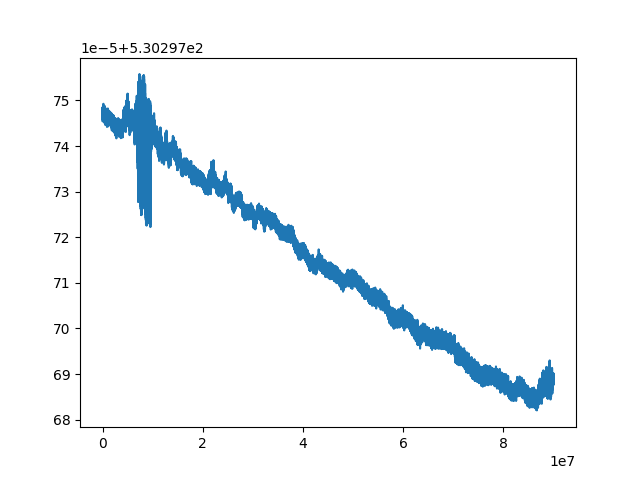

In [8]:
%matplotlib widget
plt.close("all")
plt.plot(T, Lambdas[2], label=r"$\lambda_1")
plt.show()

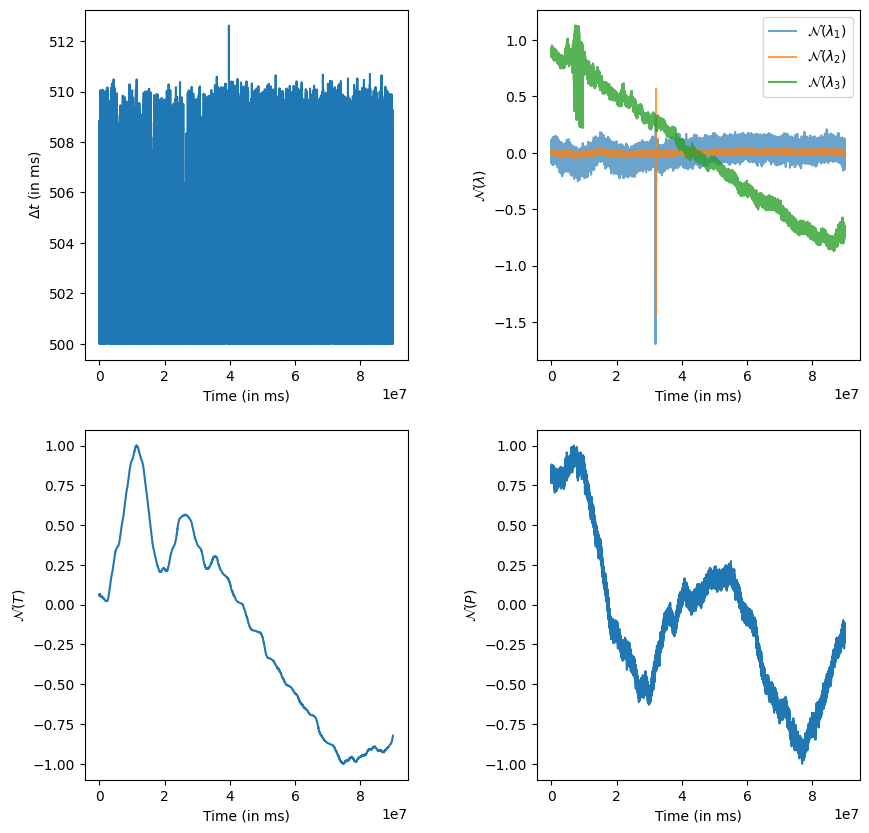

In [9]:
%matplotlib inline
plt.close()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.4)
axes[0, 0].plot(T[1:], T[1:]-T[:-1])
axes[0, 0].set_xlabel("Time (in ms)")
axes[0, 0].set_ylabel(r"$\Delta t$ (in ms)")

for i in range(len(Lambdas_norm)):
    axes[0, 1].plot(T, Lambdas_norm[i]-np.mean(Lambdas_norm[i]), label=r"$\mathcal{N}(\lambda_%d)$" %(i+1), alpha=1-1/(i+3))
axes[0, 1].legend()
axes[0, 1].set_xlabel("Time (in ms)")
axes[0, 1].set_ylabel(r"$\mathcal{N}(\lambda$)")

axes[1, 0].plot(T, Temperature_norm)
axes[1, 0].set_xlabel("Time (in ms)")
axes[1, 0].set_ylabel(r"$\mathcal{N}(T)$")

axes[1, 1].plot(T, Pressure_norm)
axes[1, 1].set_xlabel("Time (in ms)")
axes[1, 1].set_ylabel(r"$\mathcal{N}(P)$")

plt.show()

# Correlations between the wavelengths

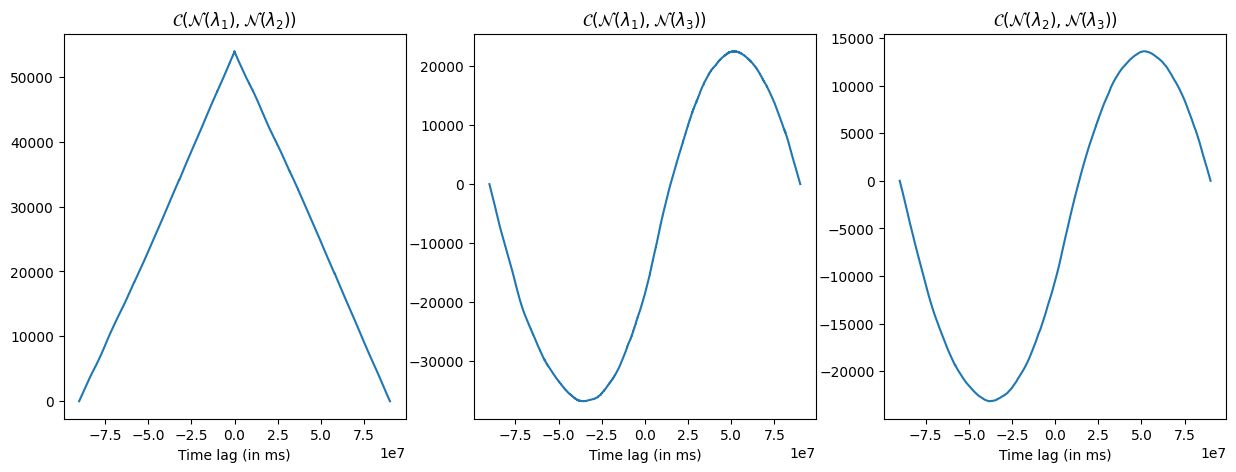

In [10]:
Corr_lambda_12 = signal.correlate(Lambdas_norm[0], Lambdas_norm[1], mode='full')
Corr_lambda_13 = signal.correlate(Lambdas_norm[0], Lambdas_norm[2], mode='full')
Corr_lambda_23 = signal.correlate(Lambdas_norm[1], Lambdas_norm[2], mode='full')
Lags = signal.correlation_lags(len(Lambdas_norm[0]), len(Lambdas_norm[1]), mode='full') * np.mean(T[1:]-T[:-1])

%matplotlib inline
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(Lags, Corr_lambda_12)
axes[0].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_1), \mathcal{N}(\lambda_2))$")
axes[0].set_xlabel(r"Time lag (in ms)")
axes[1].plot(Lags, Corr_lambda_13)
axes[1].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_1), \mathcal{N}(\lambda_3))$")
axes[1].set_xlabel(r"Time lag (in ms)")
axes[2].plot(Lags, Corr_lambda_23)
axes[2].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_2), \mathcal{N}(\lambda_3))$")
axes[2].set_xlabel(r"Time lag (in ms)")
plt.show()

# Correlations $\lambda_1$ with temperature/pressure

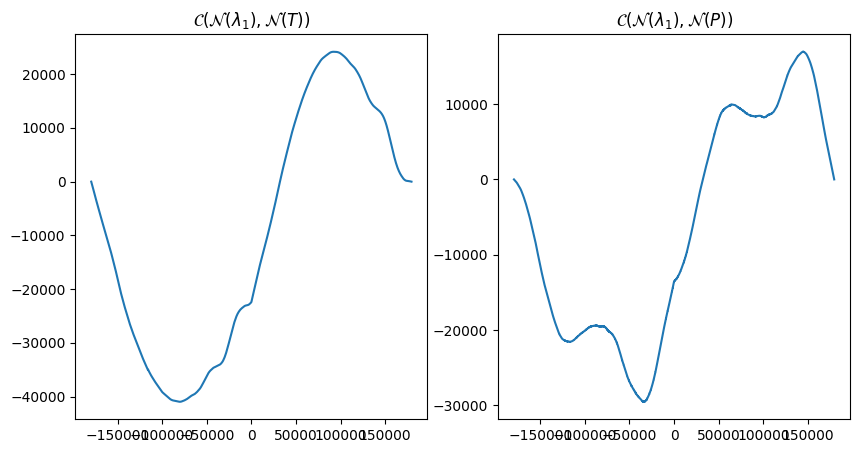

In [11]:
Corr_lambda_1T = signal.correlate(Lambdas_norm[0], Temperature_norm, mode='full')
Corr_lambda_1P = signal.correlate(Lambdas_norm[0], Pressure_norm, mode='full')
Lags = signal.correlation_lags(len(Lambdas_norm[0]), len(Temperature_norm), mode='full')

%matplotlib inline
plt.close("all")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(Lags, Corr_lambda_1T)
axes[0].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_1), \mathcal{N}(T))$")
axes[1].plot(Lags, Corr_lambda_1P)
axes[1].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_1), \mathcal{N}(P))$")
plt.show()

# Correlations $\lambda_2$ with temperature/pressure

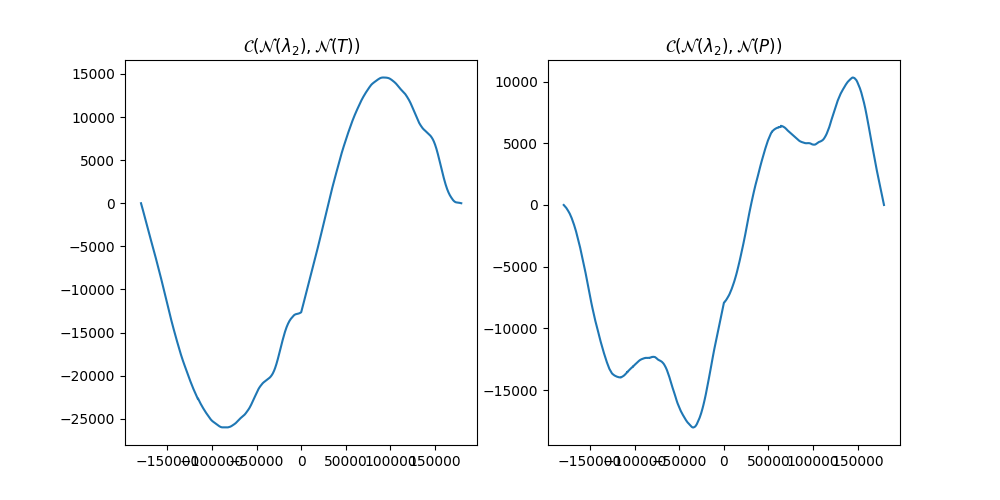

In [12]:
Corr_lambda_1T = signal.correlate(Lambdas_norm[1], Temperature_norm, mode='full')
Corr_lambda_1P = signal.correlate(Lambdas_norm[1], Pressure_norm, mode='full')
Lags = signal.correlation_lags(len(Lambdas_norm[1]), len(Temperature_norm), mode='full')

%matplotlib widget
plt.close("all")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(Lags, Corr_lambda_1T)
axes[0].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_2), \mathcal{N}(T))$")
axes[1].plot(Lags, Corr_lambda_1P)
axes[1].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_2), \mathcal{N}(P))$")
plt.show()

# Correlations $\lambda_3$ with temperature/pressure

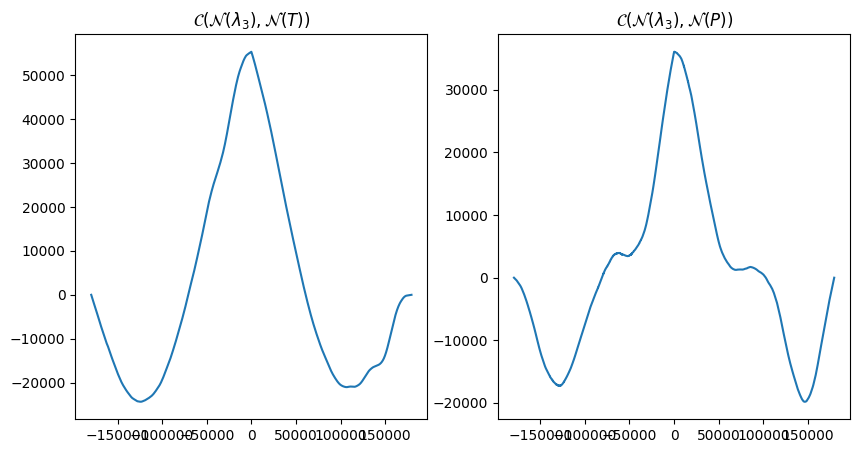

In [13]:
Corr_lambda_1T = signal.correlate(Lambdas_norm[2], Temperature_norm, mode='full')
Corr_lambda_1P = signal.correlate(Lambdas_norm[2], Pressure_norm, mode='full')
Lags = signal.correlation_lags(len(Lambdas_norm[2]), len(Temperature_norm), mode='full')

%matplotlib inline
plt.close("all")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(Lags, Corr_lambda_1T)
axes[0].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_3), \mathcal{N}(T))$")
axes[1].plot(Lags, Corr_lambda_1P)
axes[1].set_title(r"$\mathcal{C}(\mathcal{N}(\lambda_3), \mathcal{N}(P))$")
plt.show()

# Correlations temperature with pressure

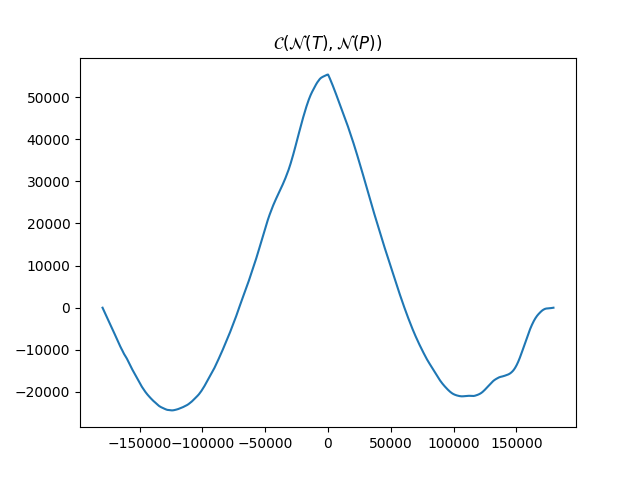

In [14]:
Corr_lambda_PT = signal.correlate(Temperature_norm, Pressure_norm, mode='full')
Lags = signal.correlation_lags(len(Temperature_norm), len(Pressure_norm), mode='full')

%matplotlib widget
plt.close("all")
fig, ax = plt.subplots()
ax.plot(Lags, Corr_lambda_1T)
ax.set_title(r"$\mathcal{C}(\mathcal{N}(T), \mathcal{N}(P))$")
plt.show()